# TUTORIAL: Build your Spam classifier with 

#### *Supervised learning for text categorization.*

The aim of this tutorial is to use NLP to create a Spam classifier.

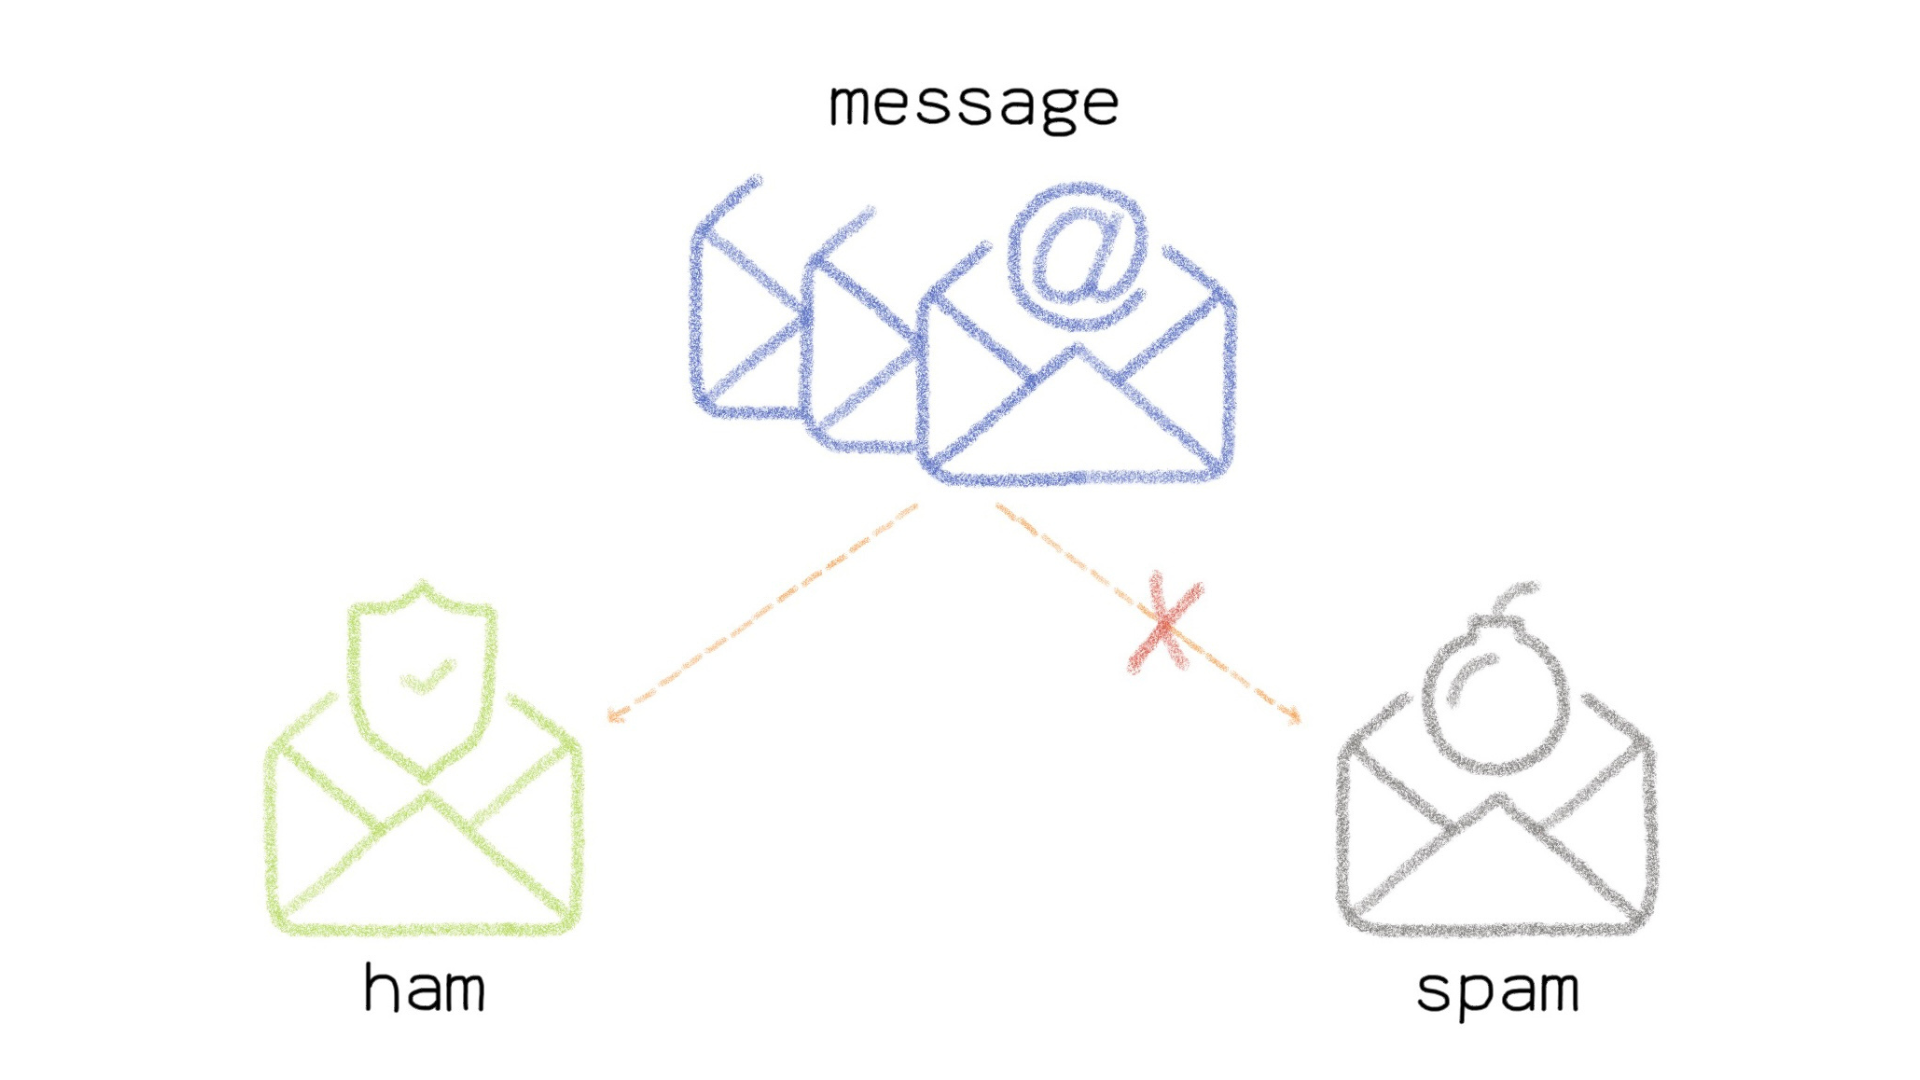

### USE CASE: Spam/Ham Dataset

This tutorial is based on the [Spam Ham Collection Dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

> You can download the `SMSSPamCollection` directly in your notebook workspace!

You can launch the following command to download the dataset:

In [ ]:
%cd /workspace
!curl -L "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip" > smsspamcollection.zip; unzip smsspamcollection.zip; rm smsspamcollection.zip

## Step 1 - Install and import dependencies

Before starting, install the Python modules.

In [ ]:
# install python libraries
!pip install pandas scikit-learn

In [3]:
# import dependencies
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Step 2 - Load the Spam/Ham dataset

In [4]:
# read the .txt file 
df = pd.read_csv('SMSSpamCollection', delimiter = "\t", names=["classe", "message"])

# display the first rows
df.head()

,classe,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# dataframe size
print("(raws, columns) =", df.shape)

(raws, columns) = (5572, 2)


## Step 3 - Data visualization 

In [6]:
# display list of columns
print("Colmuns names:", df.columns.tolist()) 

Colmuns names: ['classe', 'message']


In [7]:
# display data type
print ("Columns types:\n",df.dtypes)

Columns types:
 classe     object
message    object
dtype: object


Display descriptive statistics of the `classe` column:

In [8]:
# stat of classe column
stats_classe = df["classe"].describe() 
print("Descriptive statistics of the class column:\n",stats_classe)

Descriptive statistics of the class column:
 count     5572
unique       2
top        ham
freq      4825
Name: classe, dtype: object


**Summary of** `classe`**:**

- 2 classes: `ham` and `spam`
- Majority of the messages are `ham`
- Frequency of the `ham` class: **4825** messages out of **5572**

In [9]:
# stat of message column
stats_message = df["message"].describe() 
print("Descriptive statistics of the message column:\n",stats_message)

Descriptive statistics of the message column:
 count                       5572
unique                      5169
top       Sorry, I'll call later
freq                          30
Name: message, dtype: object


**Summary of** `message`**:**

- **5169** different messages
- Majority of messages: *"Sorry, I'll call later"*
- Frequency of this message: **30**

Display the frequency distribution of the classes thanks to `crosstab()`function from Pandas module.

In [10]:
# display classes frequency
pd.crosstab(index=df["classe"], columns="count")

col_0,count
classe,
ham,4825
spam,747


## Step 4 - Split the dataset for training and validation

- **3572** messages will be dedicated to the training set
- **2000** messages will be dedicated to the validation set

The messages will be split, via a random partition, stratified by class to preserve the proportions of `spam` and `ham` in the subsets. Indeed, the dataset is not balanced and there is less spam and it is necessary to ensure that there is a proportional amount of spam in the two subsets.

The method `train_test_split` from `sklearn.model_selection` will be used.

In [11]:
# define the X and the y columns
X = df['message']
y = df['classe']

# test size must be between 0 and 1
ntest = 2000/(3572+2000)

# slpit data: train and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=ntest, random_state=0)

Display the frequency distribution of the class attribute for the **training** and **test** set, using the `crosstab()` function in the Pandas module.

In [12]:
# train set
pd.crosstab(index=y_train, columns="count")

col_0,count
classe,
ham,3083
spam,489


In [13]:
print("Pourcentage of 'ham' messages in the training set:", round(3083*100/(3083+489), 2), "%")

Pourcentage of 'ham' messages in the training set: 86.31 %


In [14]:
# test set
pd.crosstab(index=y_test, columns="count")

col_0,count
classe,
ham,1742
spam,258


In [15]:
print("Poucentage of 'ham' messages in the test set:", round(1742*100/(1742+258), 2), "%")

Poucentage of 'ham' messages in the test set: 87.1 %


## Step 5 - Construction of the term-message matrix for training

Construct the term matrix of documents for the training corpus. The chosen weighting is binary. 

The operation is performed in two steps:
- instantiate the `CountVectorizer` calculation object
- call the `fit_transform()` method passing as parameters the messages of the training set

In [16]:
# transform the X_Train column into a list of messages
corpus = X_train.tolist()

# CountVectorizer object
vectorizer = CountVectorizer()

# fit_transform() method
Xtrain = vectorizer.fit_transform(corpus)

Display the number and list of terms:

In [17]:
# list of terms 
vectorizer.get_feature_names_out()

array(['00', '000', '000pes', ..., 'èn', 'ú1', '〨ud'], dtype=object)

In [18]:
# number of terms 
print("Number of different terms in dictionary:", len(vectorizer.get_feature_names_out()))

Number of different terms in dictionary: 6967


Calculate the frequency of the terms using `XTrain`.

In [19]:
# transform Xtrain into a numpy matrix
Xtrain = Xtrain.toarray()

Now that we have obtained a Numpy matrix, we calculate the frequency of the terms by summing each row of the matrix.

`frequency of term 1 = sum(row 1)`

...

`frequency of term n = sum(row n)`

In [20]:
# display terms frequence
freq = np.sum(Xtrain, axis=0)
print("Frequency of each term:", freq)

Frequency of each term: [ 6 17  1 ...  1  1  1]


In [21]:
# display the matrix size
print("Size of Xtrain matrix:", Xtrain.shape)

Size of Xtrain matrix: (3572, 6967)


Calculate the number of messages in which each term appears:

- use the sum in the case of binary weighting
- sort the frequency vector to highlight the most frequent terms

First, check the `vectorizer.get_feature_names_out()` format.

In [22]:
# display vectorizer.get_feature_names_out() type
print(type(vectorizer.get_feature_names_out()))

<class 'numpy.ndarray'>


Transform the list of terms into dataframe.

In [23]:
# transform names into a dataframe
df_names = pd.DataFrame(vectorizer.get_feature_names_out())
print(df_names)

                 0
0               00
1              000
2           000pes
3     008704050406
4             0121
...            ...
6962          zouk
6963         zyada
6964            èn
6965            ú1
6966           〨ud

[6967 rows x 1 columns]


Transform the Numpy array of frequences into dataframe.

In [24]:
# transform frequences into a dataframe
df_freq = pd.DataFrame(freq)
print(df_freq)

       0
0      6
1     17
2      1
3      1
4      1
...   ..
6962   1
6963   1
6964   1
6965   1
6966   1

[6967 rows x 1 columns]


Concatenate names and their frequency into a single dataframe.

In [25]:
# create the new dataframe
df_name_freq = pd.concat([df_names, df_freq], axis=1)
df_name_freq.columns = ['term', 'frequence']

# display it
print(df_name_freq)

              term  frequence
0               00          6
1              000         17
2           000pes          1
3     008704050406          1
4             0121          1
...            ...        ...
6962          zouk          1
6963         zyada          1
6964            èn          1
6965            ú1          1
6966           〨ud          1

[6967 rows x 2 columns]


For example: 
- the term "00" appears in 6 messages
- the term "000" appears in 17 messages
- ...

Sort the frequency vector to display only the most frequent terms and keep only the terms that appear more than once in the documents.

In [26]:
# create list for frequences > 1
freq_sup_one = []
term = []
i=0

# create a filter to save only frequences > 1
for i in range(len(df_name_freq)): 
    if df_name_freq['frequence'][i]>1:
        freq_sup_one.append(df_name_freq['frequence'][i])
        term.append(df_name_freq['term'][i])

# transform lists into a dataframe
df_freq_sup_one = pd.DataFrame(freq_sup_one)
df_term = pd.DataFrame(term)

# create the new dataframe
df_term_frequent = pd.concat([df_term, df_freq_sup_one], axis=1)
df_term_frequent.columns = ['termes', 'frequences>1']

# display it
print(df_term_frequent)

           termes  frequences>1
0              00             6
1             000            17
2              02             6
3     02073162414             2
4              03            11
...           ...           ...
3223        yunny             2
3224          yup            27
3225          zed             5
3226       zindgi             2
3227          zoe             2

[3228 rows x 2 columns]


## Step 6 - Creation of the model using Logistic Regression

The **Logistic Regression** is that of `sklearn` module.

In [27]:
logistic_regression = LogisticRegression()
model = logistic_regression.fit(Xtrain, y_train)

Display the **coefficients** and **intercept** of the model.

In [28]:
# model coefficients
print("Model coefficients:", model.coef_)

Model coefficients: [[ 0.07452623  0.27047205 -0.01048835 ... -0.07931082  0.10591638
  -0.00610348]]


In [29]:
# model intercpet
print("Model intercept:", model.intercept_)

Model intercept: [-4.71822738]


## Step 7 - Model evaluation on the test set

To apply the model on the test corpus, build the corresponding term-message matrix.

In [30]:
Xtest = vectorizer.transform(X_test).toarray()
print('Xtest =',Xtest)

Xtest = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Display model predictions on test set: 

In [31]:
pred = model.predict(Xtest)
print('Predictions :',pred)

Predictions : ['ham' 'spam' 'ham' ... 'ham' 'ham' 'ham']


Check the performance indicators by comparing them with the observed values on the test sample.

- Confusion matrix:

In [32]:
print('Confusion matrix:\n', confusion_matrix(y_test, pred)) 

Confusion matrix:
 [[1737    5]
 [  36  222]]


- Precision:

In [33]:
print('Precision: ', format(precision_score(y_test, pred, pos_label="ham")))

Precision:  0.9796954314720813


- Recall:

In [34]:
print('Recall: ', format(recall_score(y_test, pred, pos_label="ham")))

Recall:  0.9971297359357061


- F1:

In [35]:
print('Score F1: ', format(f1_score(y_test, pred, pos_label="ham")))

Score F1:  0.9883357041251778


- Accuracy:

In [36]:
print('Accuracy: ', format(accuracy_score(y_test, pred)))

Accuracy:  0.9795


### Note:

The values of the metrics **Accuracy**, **Recall**, **Score F1** and **Accuracy** are close to 1. This indicates a good performance of the model in classifying `ham` and `spam` messages.

## Step 8 - Dimension reduction: stop words and term frequency

In the texts, some terms are used very often and do not carry any meaning: "to", "you", "the", ... . These are **Stop Words**. 

They do not allow the documents to be distinguished and it seems appropriate to **remove** them.

On the other hand, some words that are too rare are not decisive because they are anecdotal. They can also be **removed**.

This part consists of following the same method as that used previously in the notebook but using the following functions:

- `CountVectorizer` with `stop_words = 'english'` for removing empty words
- `min_df = 10` to remove terms that appear in less than (strictly) ten messages

### 1. Training set

In [37]:
# transform the X_Train column into a list of messages
corpus_train = X_train.tolist()

# remove stop words
vectorizer = CountVectorizer(stop_words = 'english', binary=True, min_df = 10)

# fit_transform() method
Xtrain = vectorizer.fit_transform(corpus_train)

# list of terms 
data_train = vectorizer.get_feature_names_out()

In [38]:
# number of terms 
print("Number of different terms in the training set:", len(data_train))

Number of different terms in the training set: 560


In [39]:
print("List of different terms in the training set::", data_train)

List of different terms in the training set:: ['000' '03' '10' '100' '1000' '10p' '12hrs' '150' '150p' '150ppm' '16'
 '18' '1st' '2000' '250' '2nd' '50' '500' '5000' '750' '800' '8007'
 '86688' '87066' 'able' 'abt' 'ac' 'account' 'actually' 'address' 'aft'
 'afternoon' 'ah' 'aight' 'alright' 'amp' 'angry' 'answer' 'anytime'
 'apply' 'ard' 'ask' 'askd' 'asked' 'asking' 'attempt' 'available' 'await'
 'awarded' 'away' 'awesome' 'b4' 'babe' 'baby' 'bad' 'beautiful' 'bed'
 'believe' 'best' 'better' 'big' 'birthday' 'bit' 'bonus' 'book' 'bored'
 'box' 'boy' 'boytoy' 'bring' 'bt' 'bus' 'busy' 'buy' 'called' 'calling'
 'calls' 'came' 'camera' 'car' 'card' 'care' 'carlos' 'case' 'cash'
 'cause' 'chance' 'change' 'charge' 'chat' 'check' 'chennai' 'chikku'
 'choose' 'claim' 'class' 'close' 'club' 'code' 'collect' 'collection'
 'com' 'come' 'comes' 'coming' 'comp' 'company' 'congrats'
 'congratulations' 'contact' 'content' 'cool' 'cos' 'cost' 'course' 'coz'
 'cs' 'cum' 'customer' 'da' 'dad' 'darli

### 2. Test set

In [40]:
corpus_test = X_test.tolist()

# fit_transform() method
Xtest = vectorizer.transform(corpus_test)

# list of terms 
data_test = vectorizer.get_feature_names_out()

In [41]:
# number of terms 
print("Number of different terms in the test set:", len(data_test))

Number of different terms in the test set: 560


In [42]:
print("List of different terms in the test set:", data_test)

List of different terms in the test set: ['000' '03' '10' '100' '1000' '10p' '12hrs' '150' '150p' '150ppm' '16'
 '18' '1st' '2000' '250' '2nd' '50' '500' '5000' '750' '800' '8007'
 '86688' '87066' 'able' 'abt' 'ac' 'account' 'actually' 'address' 'aft'
 'afternoon' 'ah' 'aight' 'alright' 'amp' 'angry' 'answer' 'anytime'
 'apply' 'ard' 'ask' 'askd' 'asked' 'asking' 'attempt' 'available' 'await'
 'awarded' 'away' 'awesome' 'b4' 'babe' 'baby' 'bad' 'beautiful' 'bed'
 'believe' 'best' 'better' 'big' 'birthday' 'bit' 'bonus' 'book' 'bored'
 'box' 'boy' 'boytoy' 'bring' 'bt' 'bus' 'busy' 'buy' 'called' 'calling'
 'calls' 'came' 'camera' 'car' 'card' 'care' 'carlos' 'case' 'cash'
 'cause' 'chance' 'change' 'charge' 'chat' 'check' 'chennai' 'chikku'
 'choose' 'claim' 'class' 'close' 'club' 'code' 'collect' 'collection'
 'com' 'come' 'comes' 'coming' 'comp' 'company' 'congrats'
 'congratulations' 'contact' 'content' 'cool' 'cos' 'cost' 'course' 'coz'
 'cs' 'cum' 'customer' 'da' 'dad' 'darlin' 'd

### Note:

> It can be seen that there are **12** times fewer terms (560 terms against 6789 previously)!

Build your term-message matrix for the training set.

In [43]:
# transform Xtrain into a numpy matrix
Xtrain = Xtrain.toarray()
print(type(Xtrain))

<class 'numpy.ndarray'>


In [44]:
print("Xtrain =", Xtrain)

Xtrain = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Apply the **Logistic Regression** on the new training set.

In [45]:
# logistic regression
logistic_regression = LogisticRegression()
model = logistic_regression.fit(Xtrain, y_train)

In [46]:
#size of coefficients matrix
print(model.coef_.shape)

#intercept of the model
print(model.intercept_)

(1, 560)
[-3.56614178]


Build your term-message matrix for the test set.

In [47]:
# transform Xtrain into a numpy matrix
Xtest = Xtest.toarray()
print(type(Xtest))

<class 'numpy.ndarray'>


In [48]:
print("Xtest =", Xtest)

Xtest = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Apply the **Logistic Regression** on the new test set.

In [49]:
pred = model.predict(Xtest)
print('Predictions :', pred)

Predictions : ['ham' 'spam' 'ham' ... 'ham' 'ham' 'ham']


Check the performance indicators by comparing them with the observed values on the new test sample.

- Confusion matrix:

In [50]:
print('Confusion matrix:\n', confusion_matrix(y_test, pred)) 

Confusion matrix:
 [[1736    6]
 [  37  221]]


- Precision:

In [51]:
print('Precision: ', format(precision_score(y_test, pred, pos_label="ham")))

Precision:  0.979131415679639


- Recall:

In [52]:
print('Recall: ', format(recall_score(y_test, pred, pos_label="ham")))

Recall:  0.9965556831228473


- F1:

In [53]:
print('Score F1: ', format(f1_score(y_test, pred, pos_label="ham")))

Score F1:  0.9877667140825035


- Accuracy:

In [54]:
print('Accuracy: ', format(accuracy_score(y_test, pred)))

Accuracy:  0.9785


### Note:

First, the **Precision**, **Recall**, **F1 Score** and **Accuracy** metrics are close to 1 even if the number of terms is reduced (from 6789 to 560 terms). The result is rather positive because the performances are preserved. 

This confirms the performance of the model in the absence of *Stop words* and terms whose occurrence is less than *10*. 

**Conclusion:** the performances are equivalent with a passage from 6789 to 560 terms.

## Step 9 - Dimensionality reduction: post processing of the model

In this part, the goal is to try a new strategy. First you need to characterize the coefficients of the model.

To do this, you need to run the previous model coefficients on the training data in absolute values
then compute several quantiles (0, 25, 50, 75, 90, 100) on the resulting vector.

In [55]:
coeff = logistic_regression.coef_

# absolute value of the coefficients
coef_abs = np.abs(coeff)

# percentiles of the coefficients (absolute value)
quantiles = np.quantile(coef_abs,[0, 0.25, 0.5, 0.75, 0.9, 1])
print("Quantiles :", quantiles)

Quantiles : [2.11516891e-03 1.69132271e-01 2.96925537e-01 5.95631750e-01
 9.93669859e-01 2.65564724e+00]


Obtain different values sorted in ascending order and choose the first quartile to define the threshold. 

Identify the numbers of the corresponding terms.

In [56]:
# choose the first quartile (25%)
index = np.where(coeff[0] > quantiles[1])
print("Number of terms :", len(index[0]))

Number of terms : 182


### Note:

Here **182** terms were retained (compared to 560 previously, after eliminating **stopwords** and **infrequent** terms).
 
Create the corresponding term-message matrices, in train and test sets.

In [57]:
new_Xtrain = Xtrain[:, index[0]]
new_Xtest = Xtest[:, index[0]]

print("New Xtrain size:", new_Xtrain.shape)
print("New Xtest size:", new_Xtest.shape)

New Xtrain size: (3572, 182)
New Xtest size: (2000, 182)


Create a code that allows you to do the model creation, training and evaluation.

In [58]:
# create model
model = LogisticRegression()

# model fit
model.fit(new_Xtrain, y_train)

# prediction on the test set
new_pred = model.predict(new_Xtest)

# confusion matrix
print('Confusion matrix:\n', confusion_matrix(y_test, new_pred)) 

# precision
print('Precision:', format(precision_score(y_test, new_pred, pos_label="ham")))

# recall
print('Recall:', format(recall_score(y_test, new_pred, pos_label="ham")))

# score F1
print('Score F1:', format(f1_score(y_test, new_pred, pos_label="ham")))

# accuracy
print('Accuracy: ', format(accuracy_score(y_test, new_pred)))

Confusion matrix:
 [[1734    8]
 [  42  216]]
Precision: 0.9763513513513513
Recall: 0.9954075774971297
Score F1: 0.9857873791927231
Accuracy:  0.975


### Note:

The quality of the modeling is in no way affected by the reduction of the dimensionality.

## Step 10 - Model inference

One of the purposes of text categorization is to produce a function that automatically assigns a class (`spam` or `ham`) to a new message based on the model. 

For example, the message *"**A new free service for you only**"* could be classify using the model (the last one).

Transform the **message** into a vector of presence absence of the terms present in the dictionary.

In [59]:
# message
msg = ["A new free service for you only"]

# description
desc = vectorizer.transform(msg)
print("Sentence description:", desc)

Sentence description:   (0, 178)	1
  (0, 336)	1
  (0, 422)	1


In [60]:
# terms in sentence
print("The terms detected in the sentence are:", np.asarray(vectorizer.get_feature_names_out())[desc.indices])

The terms detected in the sentence are: ['free' 'new' 'service']


Transform the vector into a dense matrix and apply the variable selection.

In [61]:
# dense 
dense_desc = desc.toarray()

# variable selection
dense_select = dense_desc[:, index[0]]

Apply the `predict()` method with the last model.

In [62]:
# prediction of the class
doc_pred = model.predict(dense_select)
print("Classification of the message:", doc_pred)

Classification of the message: ['spam']


### Note:

Here, there is the result of the prediction but no indication of its accuracy. It is therefore impossible to know how well the message seems to be ranked.

Verify the previous result by calculating the probabilities of membership of the classes with the method `predict_proba()`.

In [63]:
# prediction of the class with probability
doc_pred_proba = model.predict_proba(dense_select)
print("Classification and precision of the message:", doc_pred_proba)

Classification and precision of the message: [[0.18915059 0.81084941]]


Here there is a **0.19** chance that it is a `ham` versus **0.81** chance that it is a `spam`.

This confirms that the message is indeed classified as `spam` with an accuracy of **81%**.